# Readme
Para iniciar a execução desse colab será necessário:
*   ajustar a origem do dado AmazonTitles-1.3MM na variável ***`input_file`***.
*   Informar uma chave GPT para utilização das APIs.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup do projeto

In [ ]:
# informar o caminho do arquivo fonte AmazonTiles-1.3MM em formato JSON
input_file = '/content/drive/MyDrive/Colab Notebooks/tc03_data/trn.json'

In [ ]:
!pip install tiktoken
!pip install --upgrade openai
!pip install httpx==0.27.2

In [ ]:
import os
import json
import tiktoken
import matplotlib.pyplot as plt
import pandas as pd
from openai import OpenAI

In [ ]:
# recria json com colunas selecionadas
def json_columns_cleanup(pfin, pfout, pcols):
    with open(pfin, 'r') as fin, \
        open(pfout, 'w') as fout:

        for line_number, line in enumerate(fin, 1):
            try:
                data  =json.loads(line)
                selected_data = {key: data[key] for key in pcols if key in data}
                json.dump(selected_data, fout, ensure_ascii=False)
                fout.write('\n')
            except json.JSONDecodeError as e:
                print(f'Erro de decodificação Json na linha {line_number}: {e}')
            except Exception as e:
                print(f'Erro na linha {line_number}: {e}')

# converte json em dataframe
def convert_json_to_df(pfin):
    try:
        df = pd.read_json(pfin, lines=True)
    except ValueError as e:
        with open(pfin, 'r') as f:
                data = [json.loads(line) for line in f]
        df = pd.DataFrame(data)

    return df

def remove_special_chars(text):
       # substitui caracteres especiais e espaços em branco
       return ''.join(c for c in text if c.isalnum() or c.isspace())


def dataset_cleanup(pfin):
    df_temp = pfin.copy()

    # Remover espaços em branco no início e fim de cada texto
    df_temp['title'] = df_temp['title'].apply(lambda x: x.strip() if isinstance(x, str) else x)
    df_temp['content'] = df_temp['content'].apply(lambda x: x.strip() if isinstance(x, str) else x)

    # Remoção caracteres especiais
    df_temp['title'] = df_temp['title'].astype(str).apply(remove_special_chars)
    df_temp['content'] = df_temp['content'].astype(str).apply(remove_special_chars)

    # Reformata conteúdo em minúsculo
    df_temp = df_temp.applymap(lambda x: x.lower() if isinstance(x, str) else x)

    # Filtrar conteúdo relevante
    df_temp = df_temp[(df_temp['title'].str.len() > 40) & (df_temp['content'].str.len() > 400)]

    # Remover linhas onde prompt ou completion estejam vazios após a limpeza
    df_temp = df_temp[(df_temp['title'] != '') & (df_temp['content'] != '')]

    # Remover linhas com valores nulos em qualquer coluna
    df_temp = df_temp.dropna(how='any')

    df_temp = df_temp.drop_duplicates()
    df_temp = df_temp.reset_index(drop=True)

    return df_temp

# layout GPT3
def save_gpt_jsonl(pfin, pfout):
    with open(pfout, 'w', encoding='utf-8') as fout:
        # Itere sobre cada linha do DataFrame
        for index, row in pfin.iterrows():
            # Crie o objeto com 'prompt' e 'completion'
            data = {
                'prompt': f"{row['title']} ->",
                'completion': f" {row['content']} STOPSTOP"
            }
            # Escreva o objeto no arquivo JSONL
            json.dump(data, fout, ensure_ascii=False)
            fout.write('\n')

# layout GPT4
def save_gpt4_jsonl(pfin, pfout):
    with open(pfout, 'w', encoding='utf-8') as fout:
        # Itere sobre cada linha do DataFrame
        for index, row in pfin.iterrows():
            # Crie o objeto com 'prompt' e 'completion'
            data = {
                "messages": [
                    {"role": "user", "content": f"{row['title']}"},
                    {"role": "assistant", "content": f"{row['content']}"}
                ]
            }
            # Escreva o objeto no arquivo JSONL
            json.dump(data, fout, ensure_ascii=False)
            fout.write('\n')


# converte dataframe em json
def save_json(pfin, pfout):
    with open(pfout, 'w', encoding='utf-8') as fout:
        # Itere sobre cada linha do DataFrame
        for index, row in pfin.iterrows():
            # Crie o objeto com 'prompt' e 'completion'
            data = {
                'title': f"{row['title']}",
                'content': f"{row['content']}"
            }
            # Escreva o objeto no arquivo JSONL
            json.dump(data, fout, ensure_ascii=False)
            fout.write('\n')

# Selecionar o tokenizer apropriado
tokenizer = tiktoken.encoding_for_model('gpt-4o-mini')

# Definir a função para contar tokens
def contar_tokens(texto):
    tokens = tokenizer.encode(texto)
    return len(tokens)


def filter_dataframe(df):
  filtered_df = df[
      df.apply(
          lambda row: ("author" in str(row["title"]).lower() or "author" in str(row["content"]).lower()) and ("copyright" in str(row["title"]).lower() or "copyright" in str(row["content"]).lower()),
          axis=1,
      )
  ]
  return filtered_df

In [ ]:
output_file = '/content/drive/MyDrive/Colab Notebooks/tc03_data/trn_cols_cleaned.json'
jsonl_gpt = '/content/drive/MyDrive/Colab Notebooks/tc03_data/trn_gpt.json'
selected_columns = ['title','content']

Recriando trn.json contendo somente as colunas de trabalho


---



In [ ]:
json_columns_cleanup(input_file, output_file, selected_columns)

# Início do tratamento dos dados

Convertendo json de trabalho para dataframe

---



In [ ]:
df = convert_json_to_df(output_file)

Tratamento principal do conteúdo de toda base

---



In [ ]:
df = dataset_cleanup(df)

<ipython-input-9-4a49cd6aea63>:45: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_temp = df_temp.applymap(lambda x: x.lower() if isinstance(x, str) else x)


Colunas adicionais ao dataframe para estudo dos tokens

---



In [ ]:
# Aplicar a função ao DataFrame
df['prompt_tokens'] = df['title'].apply(contar_tokens)
df['completion_tokens'] = df['content'].apply(contar_tokens)
df['total_tokens'] = df['prompt_tokens'] + df['completion_tokens']

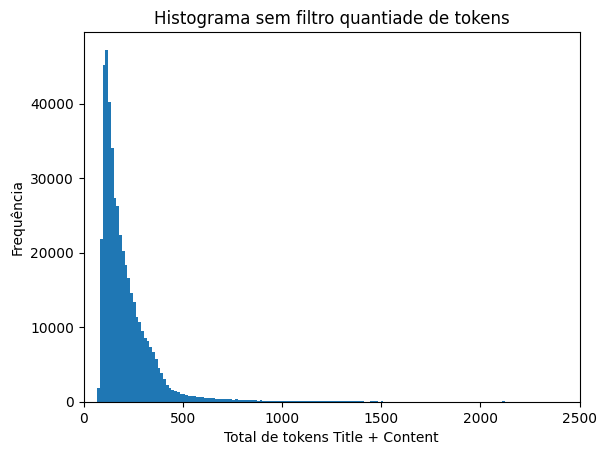

In [ ]:
plt.hist(df['total_tokens'], bins=3000)  # Adjust 'bins' as needed
plt.xlabel('Total de tokens Title + Content')
plt.ylabel('Frequência')
plt.title('Histograma sem filtro quantiade de tokens')
plt.xlim(0, 2500)
plt.show()

Filtrando quantidade máxima de tokens em 256 (title + content)

---



In [ ]:
df_max_tokens = df[df['total_tokens'] < 257]
df_max_tokens.reset_index(drop=True)


,title,content,prompt_tokens,completion_tokens,total_tokens
0,spirit ledmoving by grace in the holy spirits ...,you can flow effortlessly and powerfully in th...,11,148,159
1,apple a day the myths misconceptions and truth...,widely known in canada from hismontreal gazett...,13,241,254
2,france the beautiful cookbook authentic recipe...,though at first glance too luscious for the po...,12,192,204
3,mexico the beautiful cookbook authentic recipe...,the latest addition to this popular series is ...,12,110,122
4,california the beautiful cookbook authentic re...,two collections of californias best the latest...,9,194,203
...,...,...,...,...,...
343972,magic the gathering garruk apex predator 2102...,magic the gathering is a collectible card game...,17,166,183
343973,v4inkreg replacement brother tn750tn720 tn750 ...,the v4ink174 replacement brother tn750 tn750 h...,39,115,154
343974,2 pack v4inkreg replacement canon 120 2617b001...,the 2 pack v4ink174 replacement canon 120 2617...,35,114,149
343975,100 organic raw unrefined african shea butter ...,ingredients100 pure unrefined organic african ...,63,162,225


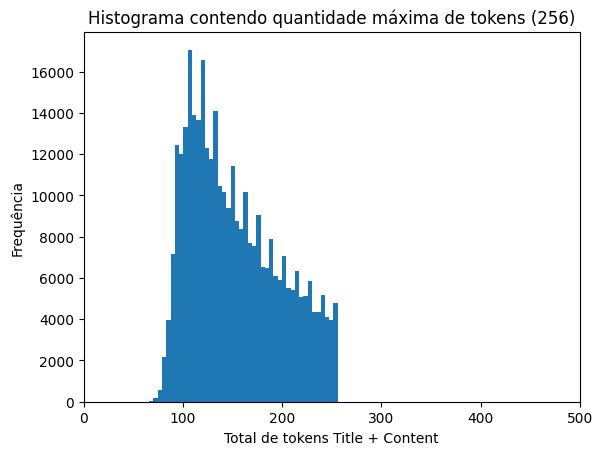

In [ ]:
plt.hist(df_max_tokens['total_tokens'], bins=50)  # Adjust 'bins' as needed
plt.xlabel('Total de tokens Title + Content')
plt.ylabel('Frequência')
plt.title('Histograma contendo quantidade máxima de tokens (256)')
plt.xlim(0, 500)
plt.show()

Filtra exemplos que contenham as palavras **author** ou **copyright**

---



In [ ]:
df_max_tokens = filter_dataframe(df_max_tokens)
df_max_tokens.reset_index(drop=True)

,title,content,prompt_tokens,completion_tokens,total_tokens
0,france the beautiful cookbook authentic recipe...,though at first glance too luscious for the po...,12,192,204
1,fuzzy thinking the new science of fuzzy logic,kosko an engineering professor at the univers...,9,211,220
2,what shall i paint how to find the right subj...,the beginning artist usually focuses on how to...,17,167,184
3,the complete short stories of thomas wolfe,next year will mark the 50th anniversary of wo...,9,214,223
4,risotto more than 100 recipes for the classic ...,this volume comprises more than 100 creative v...,15,217,232
...,...,...,...,...,...
5095,kayscase slim hard shell cover case for the ht...,kays knows about caseslip your htc one plus m8...,25,221,246
5096,kayscase slim hard shell htc one plus htc one ...,kays knows about caseslip your htc one plus m8...,33,221,254
5097,kayscase slim hard shell htc one plus htc one ...,kays knows about caseslip your htc one plus m8...,33,221,254
5098,kayscase slim soft gel tpu skin cover case for...,kays knows about caseslip your htc one plus m8...,26,220,246


Seleciona as primeiras 1500 linhas

---



In [ ]:
train_1500 = df_max_tokens.head(1500)
train_1500.reset_index(drop=True)

,title,content,prompt_tokens,completion_tokens,total_tokens
0,france the beautiful cookbook authentic recipe...,though at first glance too luscious for the po...,12,192,204
1,fuzzy thinking the new science of fuzzy logic,kosko an engineering professor at the univers...,9,211,220
2,what shall i paint how to find the right subj...,the beginning artist usually focuses on how to...,17,167,184
3,the complete short stories of thomas wolfe,next year will mark the 50th anniversary of wo...,9,214,223
4,risotto more than 100 recipes for the classic ...,this volume comprises more than 100 creative v...,15,217,232
...,...,...,...,...,...
1495,power thoughts 12 strategies to win the battle...,bestselling author and tv preacher meyer takes...,12,216,228
1496,death of a gentle lady hamish macbeth mysterie...,full of the authors trademark zest and wit bes...,13,173,186
1497,diary of a fat housewife a true story of humor...,green a former beauty queen was once slim but ...,15,195,210
1498,night train to memphis vicky bliss mysteries,comically mixing country music lyrics with egy...,9,209,218


Seleciona as linhas 1501 e 2000 (500 exemplos)

---


In [ ]:
test_500 = df_max_tokens.iloc[1500:2000]
test_500.reset_index(drop=True)

,title,content,prompt_tokens,completion_tokens,total_tokens
0,death of a dreamer hamish macbeth mysteries no 22,starred reviewbeatons flawless 21st installmen...,13,230,243
1,death of a bore hamish macbeth mysteries no 21,a macbeth utterly lacking in ambition and a ti...,12,216,228
2,to life a celebration of jewish being and thin...,kushner a rabbi and author of the bestseller w...,9,184,193
3,first you have to row a little boat reflection...,bode blue sloop at dawn uses his great love ...,13,149,162
4,herbal defense positioning yourself to triumph...,landis creator of the bodyfueling concept here...,11,225,236
...,...,...,...,...,...
495,preemies the essential guide for parents of pr...,linden and paroli mothers who met in the hospi...,10,237,247
496,buffy the vampire slayer the monster book,fans ofbuffy the vampire slayerwatch the show ...,9,175,184
497,time traders ii the defiant agents amp key out...,reluctant agents for the us governments secret...,12,118,130
498,friends in high places the bechtel story the ...,the title reflects the authors characterizatio...,20,196,216


In [ ]:
print(test_500['total_tokens'].sum())

104551


In [ ]:
print(train_1500['total_tokens'].sum())

316669


In [ ]:
save_gpt4_jsonl(train_1500, jsonl_gpt)

# Treinamento GPT

## GPT3

Preparação dados de treino GPT3

---



In [ ]:
# ferramenta openai para validar formato JSONL para o GPT3
# !openai tools fine_tunes.prepare_data -f /content/drive/MyDrive/Colab\ Notebooks/tc03_data/trn_gpt.json

Analyzing...

- Your JSON file appears to be in a JSONL format. Your file will be converted to JSONL format
- Your file contains 1500 prompt-completion pairs

ERROR in necessary_column validator: `prompt` column/key is missing. Please make sure you name your columns/keys appropriately, then retry

Aborting...

Preparação dos dados de validação GPT3

---



In [ ]:
#jsonl_gpt_validation = '/content/drive/MyDrive/Colab Notebooks/tc03_data/trn_gpt_validation.json'
#save_gpt_jsonl(test_500, jsonl_gpt_validation)

In [ ]:
#!openai tools fine_tunes.prepare_data -f /content/drive/MyDrive/Colab\ Notebooks/tc03_data/trn_gpt_validation.json

Analyzing...

- Your JSON file appears to be in a JSONL format. Your file will be converted to JSONL format
- Your file contains 500 prompt-completion pairs
- All prompts end with suffix ` ->`
- All completions end with suffix ` STOPSTOP`

Based on the analysis we will perform the following actions:
- [Necessary] Your format `JSON` will be converted to `JSONL`


Your data will be written to a new JSONL file. Proceed [Y/n]: Y

Wrote modified file to `/content/drive/MyDrive/Colab Notebooks/tc03_data/trn_gpt_validation_prepared.jsonl`
Feel free to take a look!

Now use that file when fine-tuning:
> openai api fine_tunes.create -t "/content/drive/MyDrive/Colab Notebooks/tc03_data/trn_gpt_validation_prepared.jsonl"

After you’ve fine-tuned a model, remember that your prompt has to end with the indicator string ` ->` for the model to start generating completions, rather than continuing with the prompt. Make sure to include `stop=[" STOPSTOP"]` so that the generated texts ends at the expected

## API Key

In [24]:
# Replace with your actual API key
os.environ["OPENAI_API_KEY"] = ""

In [25]:
#!openai api fine_tunes.create \
#    -t "/content/drive/MyDrive/Colab Notebooks/tc03_data/trn_gpt_prepared.json" \
#    -v "/content/drive/MyDrive/Colab Notebooks/tc03_data/trn_gpt_validation_prepared.json" \
#    -m gpt-4o-mini

## GPT4

In [28]:
file_path = '/content/drive/MyDrive/Colab Notebooks/tc03_data/trn_gpt.json'

client = OpenAI()

#client.files.create(
#  file=open(file_path, "rb"),
#  purpose="fine-tune"
#)



In [ ]:
#client.fine_tuning.jobs.create(
#  training_file="file-F15Xai2cY1JZTb5jtHT2bG",
#  model="gpt-4o-mini-2024-07-18"
#)

FineTuningJob(id='ftjob-lcdzIYCPKMvuap30JGx9Ggi2', created_at=1734215281, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-HhAd4mxs3U6L0EZAGGxmo2cs', result_files=[], seed=1618800999, status='validating_files', trained_tokens=None, training_file='file-F15Xai2cY1JZTb5jtHT2bG', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [31]:
client.fine_tuning.jobs.retrieve("ftjob-lcdzIYCPKMvuap30JGx9Ggi2")

FineTuningJob(id='ftjob-lcdzIYCPKMvuap30JGx9Ggi2', created_at=1734215281, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:personal::AeVK8y0e', finished_at=1734216890, hyperparameters=Hyperparameters(n_epochs=3, batch_size=3, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-HhAd4mxs3U6L0EZAGGxmo2cs', result_files=['file-JkeG1xjeD1YqtgRVK1pks2'], seed=1618800999, status='succeeded', trained_tokens=990507, training_file='file-F15Xai2cY1JZTb5jtHT2bG', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
import time

while True:
    jobid = client.fine_tuning.jobs.retrieve("ftjob-lcdzIYCPKMvuap30JGx9Ggi2")
    print(f"Status: {jobid.status}")
    if jobid.status in ["succeeded", "failed"]:
        break
    time.sleep(60)  # Aguarde 60 segundos antes de verificar novamente

if jobid.status == "succeeded":
    print(f"Fine-tuning concluído! Modelo ajustado: {jobid.status}")
elif jobid.status == "failed":
    print("Fine-tuning falhou. Consulte os logs para mais informações.")


Status: running
Status: running
Status: succeeded
Fine-tuning concluído! Modelo ajustado: succeeded


## Testes GPT4 vs GPT4 fine-tuned

In [34]:
content = "mastering public speaking the handbook 2nd edition"

In [35]:
completion = client.chat.completions.create(
model="gpt-4o-mini",
messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": content}
  ]
)
print(completion.choices[0].message)

ChatCompletionMessage(content='"Mastering Public Speaking" is a comprehensive guide that addresses various aspects of public speaking, including preparation, delivery, audience engagement, and the use of visual aids. While I don’t have the specific details of the 2nd edition, I can provide you with some general information on what you might expect from such a book.\n\n### Key Topics Typically Covered:\n\n1. **Understanding Your Audience**: Techniques for analyzing your audience to tailor your message effectively.\n\n2. **Speech Preparation**: Steps for structuring your speech, including choosing a topic, researching, and organizing content.\n\n3. **Types of Speeches**: Explanation of different speech types, such as informative, persuasive, and special occasion speeches.\n\n4. **Delivery Methods**: Insights on various delivery styles, including extemporaneous, memorized, and manuscript speeches.\n\n5. **Overcoming Anxiety**: Strategies for managing public speaking anxiety and building c

In [36]:
completion = client.chat.completions.create(
model="ft:gpt-4o-mini-2024-07-18:personal::AeVK8y0e",
messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": content}
  ]
)
print(completion.choices[0].message)

ChatCompletionMessage(content='this workbook offers rules calculated to promote success in public speaking like its authors tongue tied and tweedled both in the profession for over 20 yearsa and among the pithy quotationsexplosion of material included on each page of this workbook its solid research data with its numerous illotstrations hondar and crowns second edition includes new illustrations reflective of increased inclusiveness stimulating students to examine the world of public speaking more closelysix new handbooks added chapters focus on the role of mass media and internet as we perceive people in the public eye additional items include effective communicating in love or learning a language and informative speeches demonstrate the book has extensive research notes but it is carefully organized a real classroom recording of an oral presentation and newspaper reviews as one item illustrations of successful and unsuccessful speeches can be obtained they should be viewed as legal s